In [1]:
import urllib.request, json 
import pandas as pd
import numpy as np
import os
import nltk, gensim
from nltk import word_tokenize
import nltk
from nltk import regexp_tokenize
from nltk.corpus import gutenberg
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\kb910\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir('C:\\Users\\kb910\\Google 드라이브\\경배끄10\\인턴\\csv파일\\spec\\Segment관련_SUV')
data = open('size_spec_final.json').read()
data = pd.DataFrame(json.loads(data))
data.columns

Index(['Brand', 'GLOBAL_SEGMENT', 'MPG_avg', 'Segment_y', 'Y2012', 'Y2013',
       'Y2014', 'Y2015', 'Y2016', 'baseMSRP', 'base_weight', 'cargo_space',
       'exterior', 'f_head', 'f_hip', 'f_leg', 'f_shoulder', 'full_feature',
       'full_size', 'height', 'horsepower', 'interior', 'length', 'make_name',
       'model_name', 'pass_capa', 'pass_vol', 's_head', 's_hip', 's_leg',
       's_shoulder', 'track_width_front', 'track_width_rear', 'wheelbase',
       'width'],
      dtype='object')

In [3]:
data2 = data[['MPG_avg','baseMSRP', 'base_weight', 'cargo_space',
       'f_head', 'f_hip', 'f_leg', 'f_shoulder',
       'height', 'horsepower','length',
       'pass_capa', 'pass_vol', 's_head', 's_hip', 's_leg',
       's_shoulder', 'track_width_front', 'track_width_rear', 'wheelbase',
       'width']]

In [4]:
corr = data2.corr()
corr['cargo_space']

MPG_avg             -0.467171
baseMSRP             0.021449
base_weight          0.540761
cargo_space          1.000000
f_head               0.223547
f_hip                0.474042
f_leg                0.181735
f_shoulder           0.561850
height               0.675301
horsepower           0.269535
length               0.758717
pass_capa            0.647624
pass_vol             0.299543
s_head               0.131945
s_hip                0.525057
s_leg                0.377193
s_shoulder           0.559204
track_width_front    0.575342
track_width_rear     0.544428
wheelbase            0.649520
width                0.581779
Name: cargo_space, dtype: float64

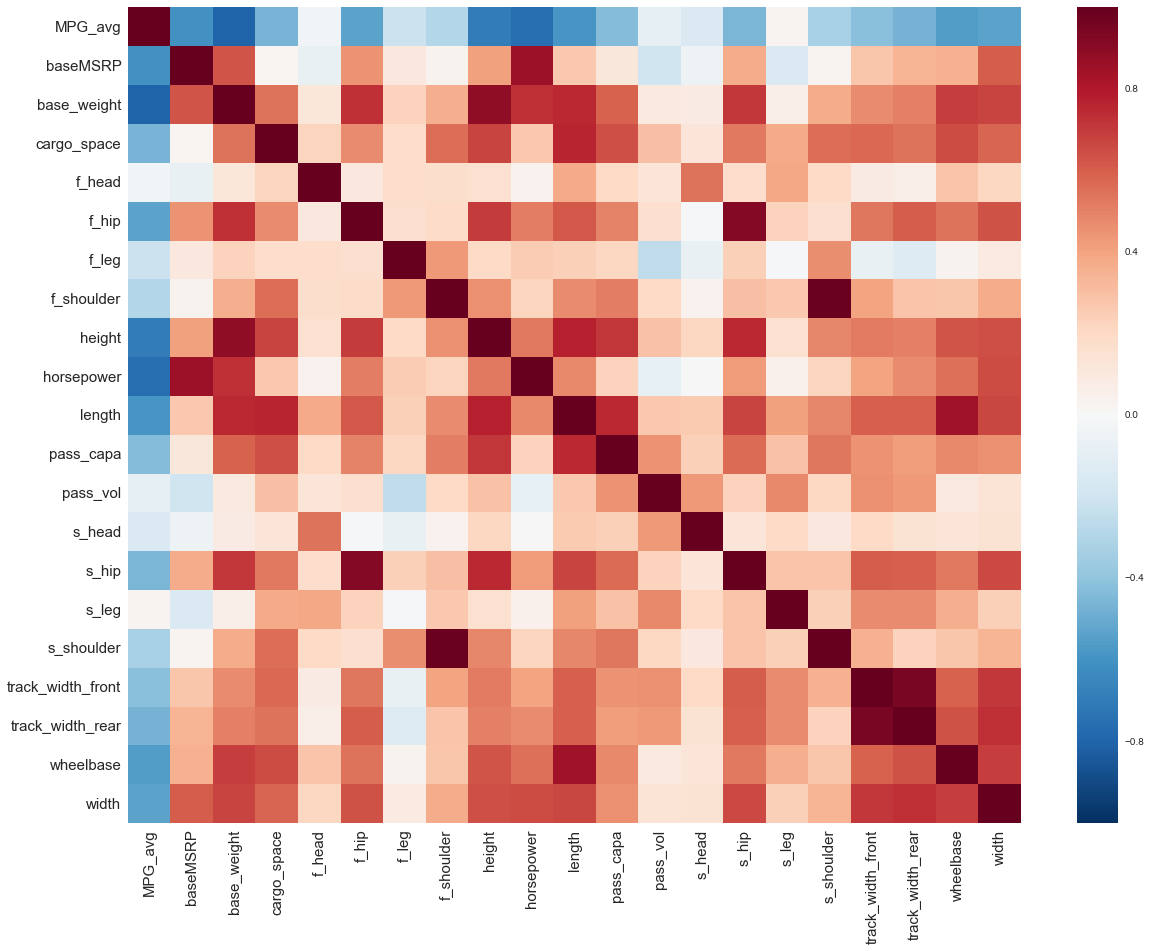

In [39]:
fig , ax = plt.subplots(1,1)
fig.set_size_inches(20,15)
sns.heatmap(corr)

plt.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('상관분석')

## 함수만들기

In [11]:
## data불러오기
def call_data(model):
    os.chdir('C:\\Users\\kb910\\Google 드라이브\\경배끄10\\인턴\\csv파일\\리뷰들\\SUV리뷰')
    data = open('all_suv_review(15~17).json').read()
    data = pd.DataFrame(json.loads(data))
    data = data[data['model_name']==model]
    data.index =[ x for x in range(len(data))]

    return data

In [8]:
# TDM_matrix로 원하는 단어가 출현하면 1 아니면 0 으로 하는 Binary Term Document Matrix 만들기

def Make_TDM(model):
    
    tdm_table = call_data(model)
    voca = ['cargo','passenger','space','capacity']
    test = [ str(x) for x in tdm_table['text'].values.tolist() ] 

    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(vocabulary=voca)
    context = test
    X = vectorizer.fit_transform(context)
    TDM_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

    for column in TDM_matrix.columns:
        TDM_matrix.loc[TDM_matrix[column] != 0, column] = 1

    TDM_matrix.loc[('sum_count')] = [ TDM_matrix[x].sum() for x in TDM_matrix.columns ]
    
    return TDM_matrix

In [9]:
# 각 리뷰 -> 각 문장에 원하는단어(Space or Cargo)가 포함되면 list에 추가하는 함수

def Make_sentence_list(model):

    TDM_matrix = Make_TDM(model)
    index_list = []
    segment_list = []

    for column in TDM_matrix.columns:
        for index in TDM_matrix.index.values:
            if(TDM_matrix[column][index] == 1):
                index_list.append(index)
                index_list = list(set(index_list))
                
    for index in index_list:
        for x in call_data(model).loc[index]['text'].split('.'):
            if 'space' in x:
                segment_list.append(x)
            elif 'cargo' in x:
                segment_list.append(x)
                
    return segment_list

In [21]:
# 감성 분석을 통해 Make_sentence_list로 추출한 각 cargoStorage관련 리뷰들을 "긍정" or "부정"으로 분류

def make_emotion(model):
    
    test_list = Make_sentence_list(model)
    
    table =pd.DataFrame(test_list)
    table.columns=['text']
    
    negetive_token = ['no']
    positive_token=['yes']
    for index, sentence in enumerate(table['text']):
        neg_count = 0
        pos_count = 0
        for word in sentence.split(" "):
            if(word in negetive_token):
                neg_count += 1
                table.loc[index,'neg'] = neg_count 
            elif(word in positive_token):
                pos_count += 1
                table.loc[index, 'pos'] = pos_count 
    
    return table
    

In [22]:
# Wordcloud로 시각화 하는 함수

def make_wordcloud(model):
    
    TDM_matrix = Make_TDM(model)
    index_list = []
    segment_list = []

    for column in TDM_matrix.columns:
        for index in TDM_matrix.index.values:
            if(TDM_matrix[column][index] == 1):
                index_list.append(index)
                index_list = list(set(index_list))
    
    max_wc=""
    for index in index_list:
        for x in call_data(model).loc[index]['text'].split('.'):
            if 'space' in x:
                max_wc = max_wc+" "+x
            elif 'cargo' in x:
                max_wc = max_wc+" "+x
                
    car_coloring = np.array(Image.open("car_test.jpg"))
    wordcloud = WordCloud(max_font_size=40,background_color="white", max_words=3000, mask=car_coloring)
    wordcloud.generate(max_wc)

    from wordcloud import ImageColorGenerator
    image_colors = ImageColorGenerator(car_coloring)
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('test4')
    plt.show()


### 감성분석 Testing

In [25]:
test = make_emotion('highlander')

In [26]:
for x in test['text']:
    print(x)

I needed enough cargo space for a wheelchair on occasion, and golf bags
 The cargo space works perfectly
 Loads of space 
 The third row is really more for small kids on trips and adults at no more than short distances and when in use the cargo space goes from great to limited
 The Pilot is cheaper when similarly equipped, has far more interior space, and is much more flexible on where child safety seats fit, having more latch points available in the 2nd and 3rd row
 Only thing I don't like is that they removed the power outlet from the rear cargo area
 The rear seat cargo room when the 3rd row is up is smaller than the Pilot but again, we don't anticipate that being a big issue and I believe it is bigger than the other cars in this class
    There is plenty of space in the front & middle rows
     It is the 3rd row and cargo area where most of the space is lost
    With the third row folder, cargo capacity is generous, though not as large as that of a Honda Pilot
   The Pilot really s

# Maxcruz 리뷰분석

In [315]:
## data불러오기
def call_data(model):
    os.chdir('C:\\Users\\kb910\\Google 드라이브\\경배끄10\\인턴\\csv파일\\리뷰들\\SUV리뷰')
    data = open('Final_maxcruz_review.json').read()
    data = pd.DataFrame(json.loads(data))
    data = data[data['model_name']==model]
    data.index =[ x for x in range(len(data))]

    return data

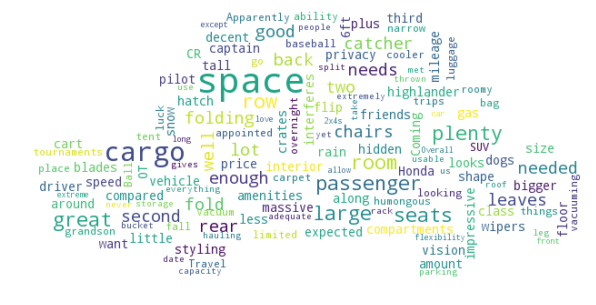

In [316]:
make_wordcloud('santa-fe')

In [305]:
maxcruz = make_emotion('santa-fe')

In [306]:
maxcruz

,text,pos,neg
0,"It leaves a 1"" space between the two wipers t...",NaN,NaN
1,There is very little room for cargo if the ba...,1.0,NaN
2,"Coming from a Honda CR-V, I needed more inter...",1.0,NaN
3,Cargo space is less compared to pilot/highlander,NaN,NaN
4,The cargo space is a plus,NaN,NaN
5,"0T was the most impressive - size, space, spee...",1.0,NaN
6,"\n\n\nThe styling is great, and the hidden com...",NaN,NaN
7,When you fold down the third row you have a g...,1.0,NaN
8,If you want to flip down the second row capta...,NaN,NaN
9,"Apparently, space is limited",NaN,NaN


In [244]:
for x in maxcruz['text']:
    print(x)

 It leaves a 1" space between the two wipers that leaves a V-shape between the blades that interferes with driver and passenger vision in rain or snow
 There is very little room for cargo if the back seats are up but that is to be expected
 Coming from a Honda CR-V, I needed more interior space to cart around my large friends (All are well above 6ft tall) and my two large dogs, along with their crates
 Cargo space is less compared to pilot/highlander
 The cargo space is a plus
0T was the most impressive - size, space, speed, gas mileage, amenities, looks and at a decent price



The styling is great, and the hidden compartments below the rear floor are bigger than any other privacy space in this vehicle class
 When you fold down the third row you have a great amount of space
 If you want to flip down the second row captain chairs (which you can do from the rear hatch) the space is massive
 Apparently, space is limited
This is a good looking, roomy, well appointed SUV with plenty of roo